# Filter Delta2 Data Caulobacter crescentus 
 
In this notebook we filter the time-lapse data of Caulobacter crescentus mutant strains with cdg sensor growing on agar-pads

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns
import pathlib

---

## Setup Folders

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')
data_dir = proj_dir / 'data_files'
image_dir = proj_dir / 'figures_Cc_Fast'
save_dir = pathlib.Path() / 'data_files'

---

## Load Data

We also add a unique ID for each cell pair (two cells with shared parent) by combining strain id, replicate id, and par id

In [3]:
#load data frame
df_name = data_dir / 'caulobacter_fast_combined_data_low_dens.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,-1,0,1,492,-1,0,[ 18 971],[ 4 1014],...,115.156010,992.979540,14.265985,0.0,0,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
1,0,0,-1,0,1,492,-1,1,[ 18 974],[ 5 1012],...,116.523438,993.010417,13.898438,0.0,1,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
2,0,0,-1,0,1,492,-1,2,[ 17 971],[ 7 1009],...,115.984375,993.117188,13.489583,0.0,2,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
3,0,0,-1,0,1,492,-1,3,[ 17 971],[ 5 1012],...,115.661538,993.097436,13.325641,0.0,3,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1
4,0,0,-1,0,1,492,-1,4,[ 17 973],[ 6 1011],...,117.321053,993.092105,12.973684,0.0,4,AKS1092,AKS1092_TL_01_2_s2,1,AKS1092-1-0,AKS1092-1--1


In [4]:
df.shape

(68849, 26)

---

## Check data

We first plot the life time distribution full lineages (those with parent and two offspring)


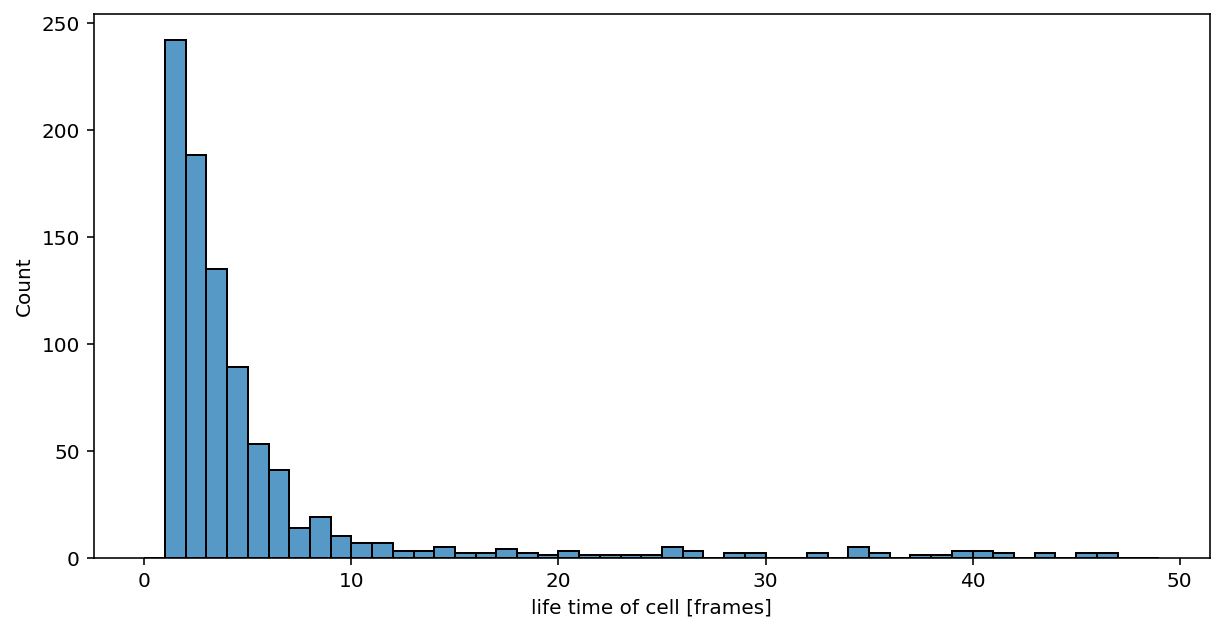

In [5]:
#plot cell life_time for full lineages
has_mom = df["id_par"] > -1
full_lin = has_mom 

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]');

Next we analyze the change in length between two frames

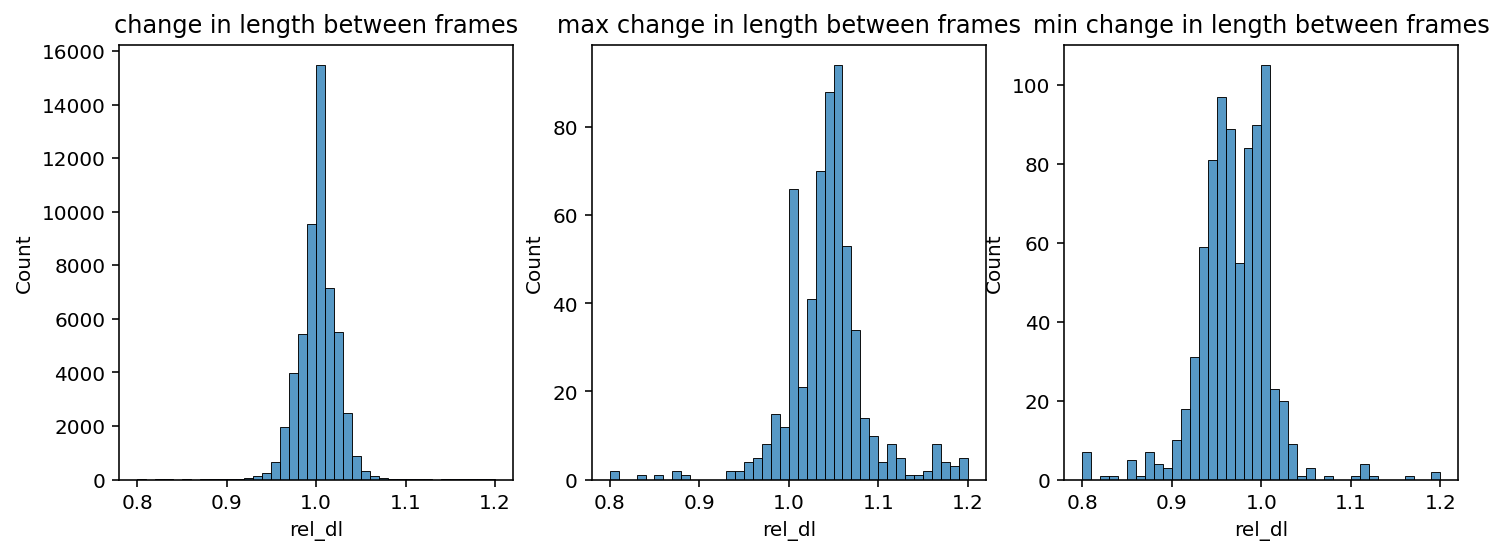

In [7]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41)).set(title='change in length between frames')
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41)).set(title='max change in length between frames')
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41)).set(title='min change in length between frames');

Next we analyze the change in length across cell divisions 

---

## Filter data

We use following checks:

 - We only consider cells whose division is properly tracked (both daughters are identified) and where both offspring cells are tracked for at least 12 frames (1h)
 - We filter out lineages where length changes too much between division
   - We calculate length change as $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where the length changes too much during life time
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$

In [42]:
def check_growth(length, min_dl, max_dl):
    """Check if change in length between frames stays within bounds

    Parameters
    ----------
    len : np.array
        length of cell over time
    min_dl : float
        lowest value of l(t+1)/l(t) that is allowed
    max_dl : float
        highest value of l(t+1)/l(t) that is allowed

    Returns
    -------
    Boolean
        True if  min_dl < l(t+1)/l(t) < max_dl for all t; false otherwise
    """
    dl = length[1:] / length[0:-1]
    
    len_ok = np.logical_and(dl>min_dl, dl<max_dl)
    
    if np.all(len_ok):
        max_frm = length.size
    elif len_ok[0]:
        max_frm = np.argmax(np.logical_not(len_ok))
    else:
        max_frm = 0
    
    return max_frm


def filter_tracks(cur_cell, filter_par, reason_skipped):
    """Filter cell tracks based on criteria

    Parameters
    ----------
    cur_cell : pd.DataFrame 
        grouped by DataFrame containing data of single cell
    filter_par : dictionary
        dictionary with filter parameter
    reason_skipped : dictionary
        dictionary that tracks reason why cell was skipped 

    Returns
    -------
    pd.DataFrame or None
        If tracking passes all criteria output is a DataFrame containing paired data of both offspring cells of cur_cell, else a None is returned 
    """
    
    #columns to copy
    cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 
            'id_par', 'frames', 'generation', 'age', 'fluo1']
    
    #init output
    new_df = None
    
    #check if division was tracked (non paired)
    has_p = cur_cell["id_par"].iloc[0] > -1
    if not has_p: reason_skipped['division not tracked'] += 1

    if has_p:
        #get offspring cells    
        #check if cell has been tracked for enough frames
        frames_ok = cur_cell.shape[0] >= filter_par['min_num_frm']
        if not frames_ok: reason_skipped['too few frames'] +=1

        if frames_ok:
            #check length change across division    
            # [l(offspring 1, t=0) +  l(offspring 2, t=0)] / l(mother, t=last)                   
        
            #check length change over time  
            max_frm = check_growth(cur_cell['length'].values, filter_par['min_dl'], filter_par['max_dl']) 
            
            len_ok = max_frm > filter_par['min_num_frm']
            
            if not len_ok: reason_skipped['dL error'] +=1

            if len_ok:
                #cell ok, process
                reason_skipped['properly tracked'] +=1
    
                #copy data frame   
                new_df = cur_cell[cols].reset_index(drop=True)
                
                #add new fields to df
                new_df['cdg'] =  new_df[filter_par['cdg_ch']] 
                
                new_df = new_df[:max_frm]
                   

    return new_df

These are the filter settings we use:

- `max_dl`: max value $l(t+1)/l(t)$ 
- `min_dl`: min value $l(t+1)/l(t)$ 
- `min_num_frm`: min number of frames to track 
- `cdg_ch`: cdg channel name

In [43]:
#filter settings
filter_par = {
        'max_dl': 1.08,  
        'min_dl': 0.92,  
        'min_num_frm': 40,
        'cdg_ch': 'fluo1'}


#keep track of why lineages are skipped
reason_skipped = { \
        'division not tracked':0,
        'too few frames':0,
        'dL error':0,
        'properly tracked':0}

#init output
df_list = []
#loop movies
movies_grouped = df.groupby('movie_name')
for _, movie in movies_grouped: 
#loop by parent cells
    cells_grouped = movie.groupby('id_cell') 
    for _, cur_cell in cells_grouped:
        # filter cells    
        new_df = filter_tracks(movie, cur_cell, filter_par, reason_skipped)
        if new_df is not None:
                df_list.append(new_df)
                
              
df_filtered = pd.concat(df_list) if len(df_list)>0 else None    
df_filtered.shape          

(45381, 11)

Show reason why lineages were skipped

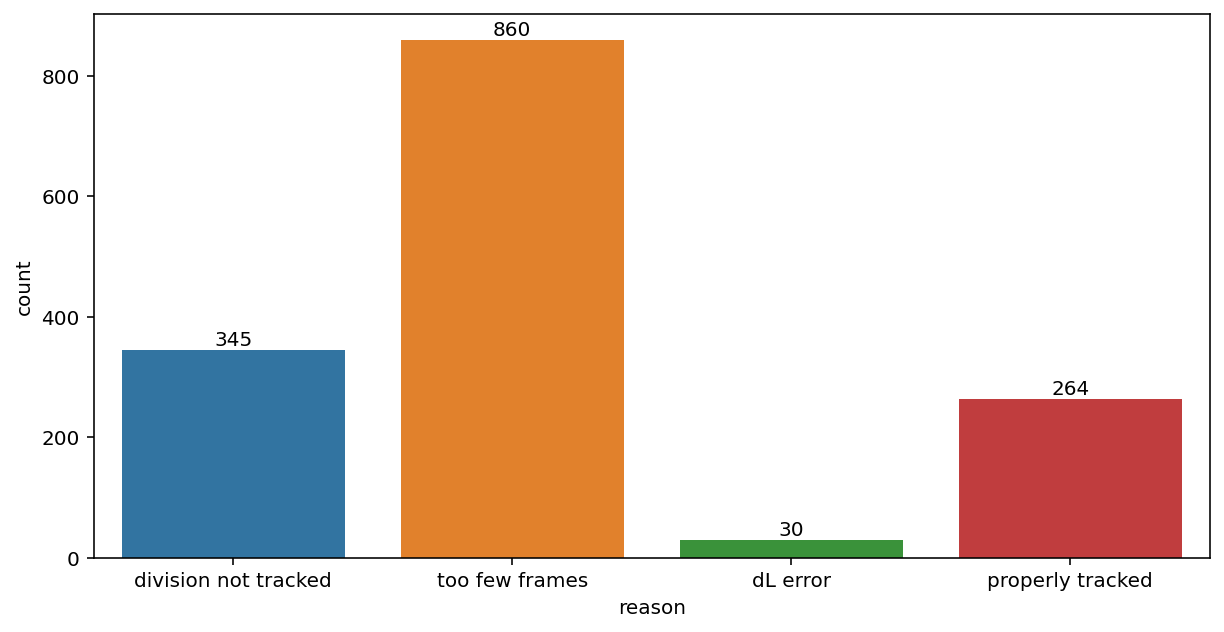

In [44]:
df_stats = pd.DataFrame( [ [k,v] for k,v in reason_skipped.items()],columns=['reason','count'])
ax = sns.barplot(data=df_stats, x='reason', y='count')
ax.bar_label(ax.containers[0]);

---

## Store Data

In [45]:
#add time in minutes
df_filtered['time since birth [min]'] = df_filtered['age'] * 0.5
df_filtered.head()

,uni_par_id,strain,movie_name,replicate,id_colony,id_par,frames,generation,age,fluo1,cdg,time since birth [min]
0,AKS1092-1-1,AKS1092,AKS1092_TL_01_2_s2,1,0,1,88,2.0,0,191.193916,191.193916,0.0
1,AKS1092-1-1,AKS1092,AKS1092_TL_01_2_s2,1,0,1,89,2.0,1,192.241107,192.241107,0.5
2,AKS1092-1-1,AKS1092,AKS1092_TL_01_2_s2,1,0,1,90,2.0,2,190.132576,190.132576,1.0
3,AKS1092-1-1,AKS1092,AKS1092_TL_01_2_s2,1,0,1,91,2.0,3,193.149425,193.149425,1.5
4,AKS1092-1-1,AKS1092,AKS1092_TL_01_2_s2,1,0,1,92,2.0,4,192.326848,192.326848,2.0


In [46]:
out_name = save_dir / 'filtered_data_Cc_Fast.csv'
df_filtered.to_csv(out_name)

KeyboardInterrupt: 

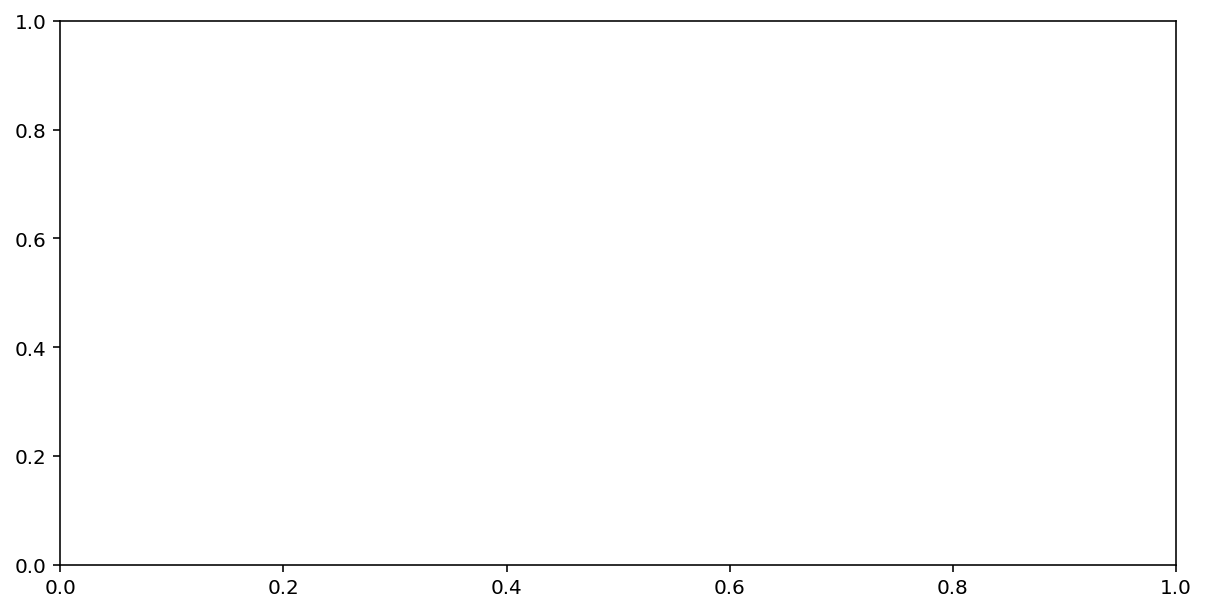

In [48]:
sns.histplot(data=df_filtered, y='cdg')